# Численное интегрирование

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
import sys
sys.path.append('../numeric-core')
import numeric

Для приближённого вычисления интеграла используется формула Симпсона на равномерной сетке:

\begin{align*}
\int\limits_a^b f(x) dx \approx \frac{b-a}{6}{ \left( f(a) + 4 f\left(\frac{a+b}{2}\right) + f(b) \right)}
\end{align*}

На одном сегменте пограшеность не превосходит

\begin{align*}
\frac{(b - a)^5}{2880} \max\limits_{x \in [a, b]} \left| f^{(4)}(x) \right|
\end{align*}

In [3]:
def estimate_error(derivative_4, derivative_5_roots, a, b, n):
    n = (n + 1) // 2
    
    error = 0.0
    x = np.linspace(a, b, n)
    
    for i in range(1, n):
        left = x[i - 1]
        right = x[i]
        
        max_val = max(np.abs(derivative_4(left)), np.abs(derivative_4(right)))
        for root in derivative_5_roots:
            if left < root < right:
                max_val = max(max_val, np.abs(derivative_4(root)))
        
        error += 1 / 2880 * np.power(right - left, 5) * max_val
    
    return error

In [4]:
def run(func, a, b, derivative_4=None, derivative_5_roots=None, value=None, f_graph=True):
    if f_graph:
        x = np.linspace(a, b, 1000)
        plt.plot(x, np.vectorize(func)(x))
        plt.xlabel(r'$x$')
        plt.ylabel(r'$f(x)$')
        plt.show()
    
    def calc(n):
        return (
            numeric.integral_simpson(func, a, b, n),
            estimate_error(derivative_4, derivative_5_roots, a, b, n) if derivative_4 is not None else None
        )
    
    if value is None:
        value, eps = scipy.integrate.quad(func, a, b, limit=10**7, epsabs=1e-18)
        
    x = np.unique(np.round(np.logspace(np.log10(1), 5)))
    arr = np.array([calc(int(2 * i + 1)) for i in x])
    
    values = np.full(len(x), value)
    absolute_error = np.abs(arr[:,0] - values)
    
    plt.figure(figsize=(10, 8))
    plt.plot(x, absolute_error, color='r', label='Simpson error')
    if derivative_4 is not None:
        plt.plot(x, arr[:,1], color='b', label='Estimated error')
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel(r'grid size')
    plt.ylabel(r'absolute error')
    plt.legend(loc=3)

## Пример 1

\begin{align*}
f(x) &=& \sin(10x) \\
f^{(4)}(x) &=& 10\,000\cdot\sin(10x) \\
f^{(5)}(x) &=& 0\; \text{при}\; x = \frac{\pi n}{10} - \frac{\pi}{20}, n \in \mathbb{Z}
\end{align*}

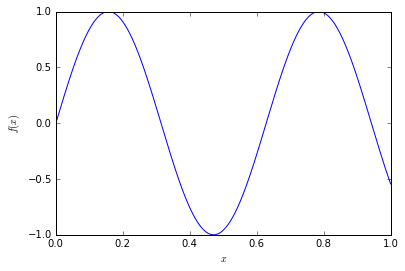

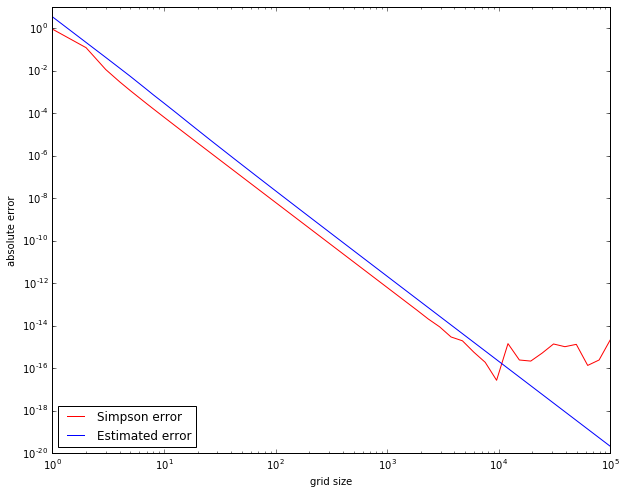

In [5]:
func = lambda x: np.sin(x * 10)
derivative_4 = lambda x : 10000 * np.sin(10 * x)

run(func, 0, 1,  derivative_4, [np.pi / 20, np.pi * 3 / 20, np.pi / 4])

(По оси $x$ отложено количество отрезков $n$, количество точек &mdash; $2n + 1$.)

## Пример 2

Многочлен.

In [6]:
class Polynom:
    def __init__(self, c):
        self.c = c
    
    def __call__(self, x):
        ret = 0.0
        for idx, c in enumerate(self.c):
            ret += np.power(x, idx) * c
        return ret
    
    def derivative(self, power):
        ret = []
        mul = 1.0
        for idx, c in enumerate(self.c):
            if idx + 1 > power:
                ret.append(mul * c)
                mul *= idx + 1
                mul /= (idx + 1) - power
            else:
                mul *= idx + 1
        
        return Polynom(ret)

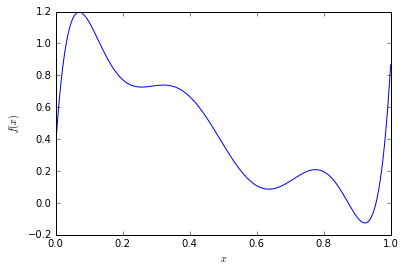

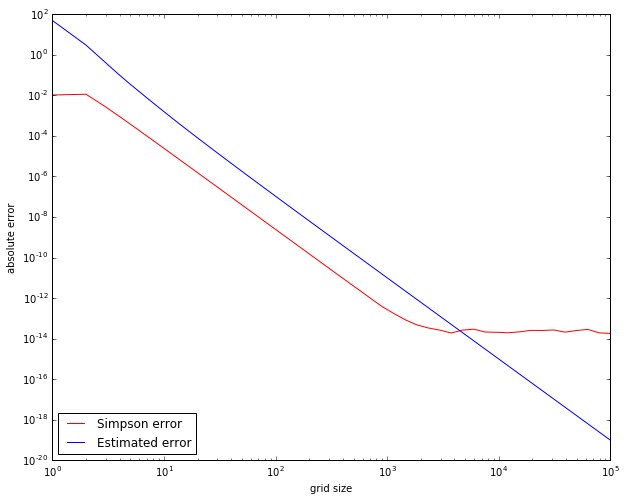

In [7]:
np.random.seed(42)

x = np.linspace(0, 1, 8)
y = [np.random.random() for _ in x]

polynom = Polynom(np.polyfit(x, y, len(x) - 1)[::-1])
run(polynom, 0, 1, polynom.derivative(4), np.roots(polynom.derivative(5).c[::-1]))

## Пример 3


\begin{align*}
f_N(x) = \frac{\left\lfloor Nx \right\rfloor}{N}
\end{align*}

Не будем аналитически оценивать погрешность разрывной функции.

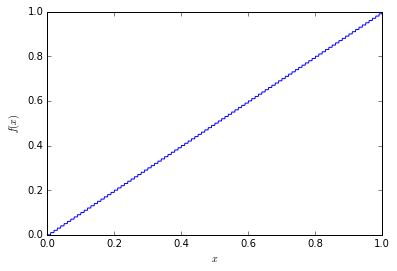

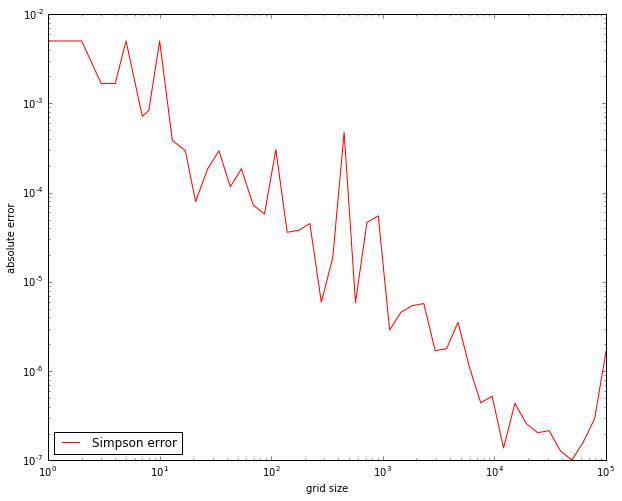

In [8]:
N = 1e2
func = lambda x: np.floor(N * x) / N

run(func, 0, 1)

Более плотная лесенка:

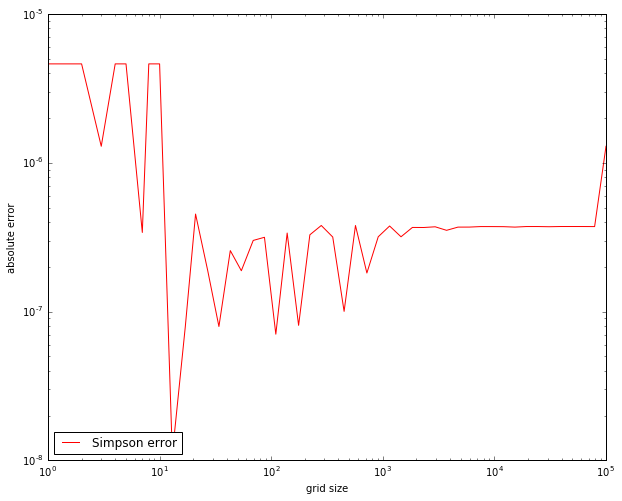

In [9]:
N = 1e5
func = lambda x: np.floor(N * x) / N

run(func, 0, 1, f_graph=False)

## Пример 4

\begin{align*}
f(x) &=& x \cdot sin(1\,000x) \\
f(x)^{(4)} &=& -4\,000\,000\,000 \cdot \left(\cos(1\,000 x) - 250 \cdot x \sin(1\,000 x)\right)
\end{align*}

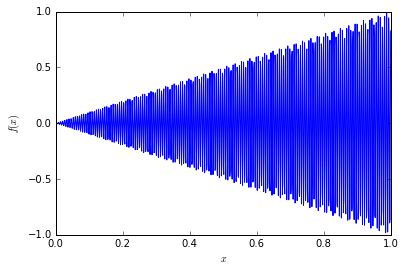

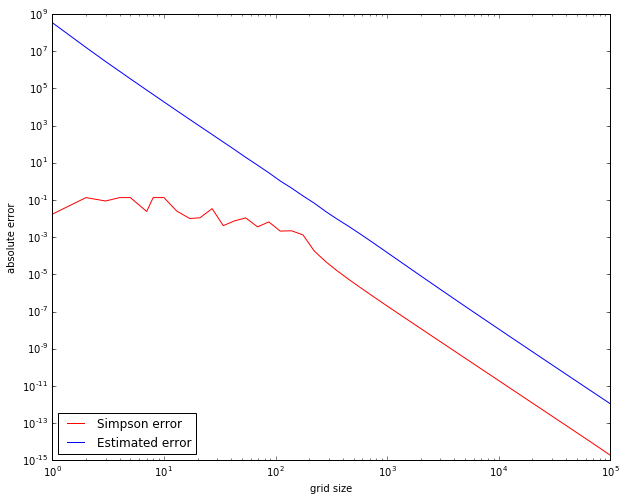

In [10]:
func = lambda x: x * np.sin(1e3 * x)
derivative_4 = lambda x : -4000000000 * (np.cos(1000 * x) - 250 * x * np.sin(1000 * x))
derivative_5 = lambda x : 5000000000000 * (np.sin(1000 * x) + 200 * x * np.cos(1000 * x))

roots = []
for x in np.linspace(0, 1, 10**6):
    if abs(derivative_5(x + 1e-6)) > abs(derivative_5(x)) < abs(derivative_5(x - 1e-6)) and derivative_5(x) < 1e-16:
        roots.append(x)

run(func, 0, 1, derivative_4, roots)

(Оценка погрешности неточная: возможно, найдены не все корни пятой производной.)

## Пример 5

\begin{align*}
f(x) = e^x \cdot \sin(100\,000 x)
\end{align*}

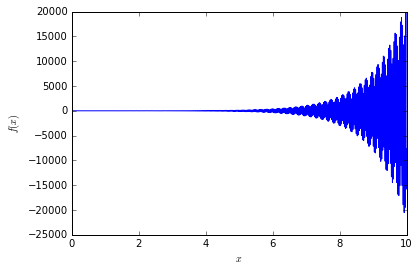

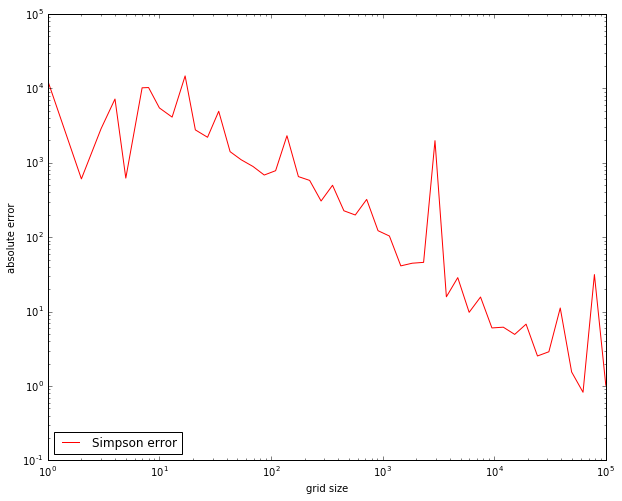

In [11]:
func = lambda x: np.power(np.e, x) * np.sin(1e5 * x)

run(func, 0, 10)

#### Как и следовало ожидать, на разрывных и осциллирующих функциях алгоритм даёт большую погрешность. На разрывных функциях алгоритм не сходится.